In [ ]:
# Restart with command below if keras uses Theano backend
# KERAS_BACKEND=tensorflow jupyter notebook --no-browser

## Network "works" but is not accurate (not better than random)  
### Things to try:  
* different number of frames per video  
* frame augmentation  
* manually adjust videos where subject is not centered  
* get more data (videos) - only have 120

In [28]:
import numpy as np
from time import sleep
import sys

import tensorflow as tf
import keras
from keras.applications import InceptionV3
from keras.models import Model
from keras.layers import Input, Dense, Activation, TimeDistributed, LSTM, Dropout, Lambda
from keras.preprocessing import image

from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

%matplotlib inline
import matplotlib.pyplot as plt
import pylab
from PIL import Image
import imageio
#imageio.plugins.ffmpeg.download()

import scipy
import os

In [2]:
EPOCHS = 5
VIDEO_FOLDER = (os.getcwd() + '/videos/Clips')
BATCH_SIZE = 3
FRAME_SQUARE_DIM = 178
FRAMES_PER_VIDEO = 30
KEEP_PROB = 1.0
TEST_SIZE = 0.2

In [8]:
keras.backend.set_learning_phase(0)

In [9]:
def get_model(frames_per_video, frame_square_dim, keep_prob):
    # Video file placeholder. Shape = (# of frames, frame-width, frame-length, # of frame-channels (i.e. rgb))
    video_input = Input(shape=(frames_per_video, frame_square_dim, frame_square_dim, 3), name='video_input')

    # TRANSFER LEARNING LAYER
    # Initialize CNN with weights from InceptionV3 trained on Imagenet.
    IncV3 = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

    # Freeze Inception layers, so we can use the already trained weights that represent lower level
    # vision and pattern recognition.
    IncV3.trainable = False
    
    # TIME DISTRIBUTION LAYER
    # Run each frame through an InceptionV3 CNN layer.
    encoded_frames = TimeDistributed(Lambda(lambda x: IncV3(x)), name='encoded_frames')(video_input)

    # LSTM LAYER
    # Run each frames CNN output through the LSTM layer.
    encoded_vid = LSTM(256, name='encoded_vid')(encoded_frames)

    # ADDITIONAL LAYERS TO TRAIN NEW CLASSES from our new video footage.
    # Add a fully-connected layer with a dropout before predictions.
    dense_relu = Dense(1024, activation='relu', name='dense_relu')(encoded_vid)
    #dense_dropout = Dropout(keep_prob, name='dense_dropout')(dense_relu)

    # Add a logistic layer with 2 new classes - "Lying" and "Truth".
    predictions = Dense(1, activation='sigmoid', name='predictions')(dense_relu)

    # Throw it all into a Model object.
    model = Model(inputs=[video_input], outputs=predictions)

    # Compile the model.
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [10]:
model = get_model(FRAMES_PER_VIDEO, FRAME_SQUARE_DIM, KEEP_PROB)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
video_input (InputLayer)     (None, 30, 178, 178, 3)   0         
_________________________________________________________________
encoded_frames (TimeDistribu (None, 30, 2048)          0         
_________________________________________________________________
encoded_vid (LSTM)           (None, 256)               2360320   
_________________________________________________________________
dense_relu (Dense)           (None, 1024)              263168    
_________________________________________________________________
predictions (Dense)          (None, 1)                 1025      
Total params: 2,624,513.0
Trainable params: 2,624,513.0
Non-trainable params: 0.0
_________________________________________________________________
None


In [25]:
# Make Frames directories in Truthful and Deceptive folders
if not os.path.exists((VIDEO_FOLDER + '/Truthful/Frames')):
    os.mkdir(VIDEO_FOLDER + '/Truthful/Frames')
if not os.path.exists((VIDEO_FOLDER + '/Deceptive/Frames')):
    os.mkdir(VIDEO_FOLDER + '/Deceptive/Frames')

In [11]:
def resize_and_crop(frame, square_dim):
    # get aspect ratio
    aspect = frame.size[0]/frame.size[1]
    
    # resize to 178 on shortest side and keep original aspect ratio
    frame = frame.resize((int(square_dim*aspect), square_dim))
    
    # crop 178 square from center
    half_the_width = frame.size[0] / 2
    half_the_height = frame.size[1] / 2
    frame = frame.crop(
        (
            half_the_width - (square_dim/2),
            half_the_height - (square_dim/2),
            half_the_width + (square_dim/2),
            half_the_height + (square_dim/2)
        )
    )
    
    return frame

In [12]:
def get_frames_from_videos(folder, frames_per_video, frame_square_dim):
    
    # get one video at a time in the folder
    vid_counter = 0
    for video_file in os.listdir(folder):
        vid_counter += 1
        
        if video_file not in ['Frames']:
            # printing status
            sys.stdout.write('\r')
            sys.stdout.flush()
            sys.stdout.write('Getting frames for video ' + str(vid_counter) + ' of ' + str(len(os.listdir(folder))))
            sys.stdout.flush()
            
            video = (folder + '/' + video_file)
            video = imageio.get_reader(video,  'ffmpeg')

            # get 30 evenly spaced frames per video
            step = video.get_meta_data()['nframes'] / frames_per_video
            frames_to_get = range(1, video.get_meta_data()['nframes'], int(step))
            frames = []
            for i in frames_to_get:
                frames.append(i)

            # only get first 30 frames if there are 31
            frames = frames[:30]

            # Resize, crop, and save each frame in the Frames folder
            ## ex: (os.getcwd + '/videos/Clips/Truthful/Frames') for Truth videos
            for frame in frames:
                this_frame = video.get_data(frame)
                imageio.imwrite("this_frame.jpg", this_frame)
                this_frame = Image.open("this_frame.jpg")
                this_frame = resize_and_crop(this_frame, frame_square_dim)
                this_frame.save((folder + '/Frames/' + video_file + '_0' + str(frame) + '.jpg'))
                
    print('\n')
    print('Complete!')

In [13]:
def get_data(folder, frames_per_video):
    X = []
    y = []

    for vid_type in os.listdir(folder):
        if not vid_type.startswith('.'):
            if vid_type in ['Deceptive']:
                label = 'Deceptive'
            else:
                label = 'Truthful'
            
            video_tensor = []
            frame_counter = 1
            frame_files = os.listdir(folder + '/' + vid_type + '/Frames')
            for frame_file_iter in range(len(frame_files)):
                if frame_file_iter == 0:
                    continue
                
                frame = (folder + '/' + vid_type + '/Frames/' + frame_files[frame_file_iter])

                frame = Image.open(frame)

                frame_tensor = np.asarray(frame.convert('RGB'))
                
                video_tensor.append(frame_tensor)
                
                if frame_counter == frames_per_video:
                    X.append(video_tensor)
                    y.append(label)
                    
                    video_tensor = []
                    frame_counter = 0
                    
                frame_counter += 1
                
    X = np.asarray(X)
    y = np.asarray(y)
    print('Complete!')
    return X,y

In [30]:
# Prepare video clips into a resized and cropped series of frames for each video
get_frames_from_videos((VIDEO_FOLDER + '/Deceptive'), FRAMES_PER_VIDEO, FRAME_SQUARE_DIM)

Getting frames for video 2 of 62

KeyboardInterrupt: 

In [37]:
# Prepare video clips into a resized and cropped series of frames for each video
get_frames_from_videos((VIDEO_FOLDER + '/Truthful'), FRAMES_PER_VIDEO, FRAME_SQUARE_DIM)

Complete!rames for video 61 of 61


In [14]:
# Get video tensors ready for network input
X, y = get_data(VIDEO_FOLDER, FRAMES_PER_VIDEO)

Complete!


In [15]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)
print('Complete!')

Complete!


In [19]:
# Encode target labels
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [20]:
# Train the model on the new video footage.
X_train = X_train.astype('float32')

# fits the model on batches
history = model.fit(
    X_train,
    y_train,
    validation_split=TEST_SIZE,
    epochs=EPOCHS,
    shuffle=True,
    batch_size=BATCH_SIZE)

#model.save_weights('binary_model.h5')

Train on 76 samples, validate on 19 samples
Epoch 1/5
76/76 [==============================] - 196s - loss: 0.7733 - acc: 0.5000 - val_loss: 0.6249 - val_acc: 0.6842

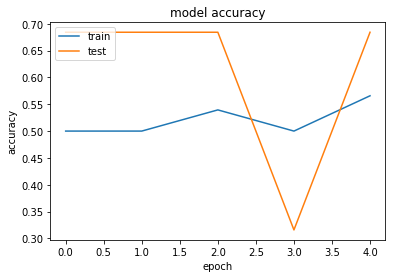

In [27]:
def plot_learning_curve(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.show()

plot_learning_curve(history)

In [40]:
# Test on the out of sample (test) video footage.
X_test = X_test.astype('float32')

print('Predicting on test data')
y_pred = np.rint(model.predict(X_test))

print(accuracy_score(y_test, y_pred))

Predicting on test data
0.5


In [41]:
# Show confusion matrix
print(confusion_matrix(y_test, y_pred))

[[ 0 12]
 [ 0 12]]


In [44]:
for test,pred in zip(y_test, y_pred):
    print(str(test) + ' : ' + str(pred[0]))

0 : 1.0
1 : 1.0
0 : 1.0
0 : 1.0
0 : 1.0
1 : 1.0
1 : 1.0
0 : 1.0
1 : 1.0
1 : 1.0
0 : 1.0
1 : 1.0
0 : 1.0
1 : 1.0
0 : 1.0
0 : 1.0
1 : 1.0
0 : 1.0
1 : 1.0
1 : 1.0
1 : 1.0
0 : 1.0
1 : 1.0
0 : 1.0
